In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

In [3]:
import torch
import random
import numpy as np
from src.models import CustomDeepLabV3 as CDL
from src.utils.config import load_config
from src.data.transforms import build_transforms_from_config
from src.data.dataset2d import PancreasDataset2D
from scripts.eval import visualize_model_predictions
from src.metrics.segmentation import SegmentationMetrics as SM
from src.metrics.segmentation_bak import SegmentationMetrics as SMbak
from src.metrics.segmentation_monai import SegmentationMonaiMetrics as SMM
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [4]:
MODEL_PATH = 'experiments/deep_aug_randcrop/deep_aug_randcrop_20250319_074330/checkpoints/best_model_epoch21.pth'
model = CDL(num_classes=5, dropout_rate=0.2, pretrained=False)
checkpoint = torch.load(MODEL_PATH, map_location='cpu')['model']
model.load_state_dict(
    {k: v for k, v in checkpoint.items() if "aux_classifier" not in k},
    strict=False
)
model.eval();

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = load_config('configs/experiments/deep_aug_randcrop.yaml')
transform = build_transforms_from_config(config.get('transforms', None))
train_ds = PancreasDataset2D(
    data_dir='data/processed/2d/train',
    transform=transform,
    load_into_memory=False
)
val_ds = PancreasDataset2D(
    data_dir='data/processed/2d/val',
    transform=transform,
    load_into_memory=False
)

📊 Loading dataset... 7004 slices found.
📊 Loading dataset... 1830 slices found.


In [6]:
def get_index(dataset, patient_id, slice_idx):
    key = f'image_{patient_id}_{slice_idx:03d}.npy'
    return sorted(dataset.metadata.keys()).index(key)

def check_prediction(model, dataset, idx, device, alpha=0.5):
    cmap = mcolors.ListedColormap(['green', 'purple', 'red', 'blue'])
    boundaries = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    model.eval()

    image, mask, patient_id = dataset[idx] 
    image, mask = image.to(device), mask.to(device)
    mask_un = mask.unsqueeze(0)

    with torch.no_grad():
        output = model(image.unsqueeze(0))["out"]
        print(output.shape)
        print(mask_un.shape)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        ground_truth = mask.cpu().numpy()

    vol_slice = dataset.get_volume_slice_idx(idx)

    # Compute Dice Score for each class
    dice_scores = [
        2 * np.sum((prediction == class_idx) & (ground_truth == class_idx)) / 
        (np.sum(prediction == class_idx) + np.sum(ground_truth == class_idx) + 1e-6) 
        for class_idx in range(1, 5)
    ]

    pred_one_hot, mask_one_hot = SM.convert_to_one_hot(output, mask_un)
    print(pred_one_hot.unique())
    print(f"\tpancreas pred: {pred_one_hot[:, 1, ...].unique()} | {torch.sum(pred_one_hot[:, 1, ...])}")
    print(f"\ttumor pred: {pred_one_hot[:, 2, ...].unique()} | {torch.sum(pred_one_hot[:, 2, ...])}")
    print(f"\tpancreas mask: {mask_one_hot[:, 1, ...].unique()}  | {torch.sum(mask_one_hot[:, 1, ...])}")
    print(f"\ttumor mask: {mask_one_hot[:, 2, ...].unique()} | {torch.sum(mask_one_hot[:, 2, ...])}")

    _, dice_scores_actual = SM.dice_coefficient(output, mask_un)
    # print(dice_scores_actual)
    _, dice_scores_bak = SMbak.dice_coefficient(output, mask_un)
    # print(dice_scores_bak)
    _, dice_scores_monai = SMM.compute_dice(output, mask_un)

    print('='*100)
    print(f"DICE SCORES: {patient_id} - {vol_slice}")
    class_names = {
        1: 'Pancreas',
        2: 'Tumor',
        3: 'Arteries',
        4: 'Veins'
    }
    print(f"{'Class':<10}{'Function':>15}{'Actual':>15}{'Previous':>15}{'MONAI':>15}{'EQ func':>15}{'EQ new':>15}")
    print("-" * 100)

    for idx in class_names:
        key = f'dice_class_{idx}'
        func = np.round(dice_scores[idx-1], 6)
        actual = np.round(dice_scores_actual[key], 6)
        previous = np.round(dice_scores_bak[key], 6)
        monai = np.round(dice_scores_monai[key], 6)

        eq_func = func==monai
        eq = actual==monai

        print(f"{class_names[idx]:<10}{func:>15,}{actual:>15,}{previous:>15,}{monai:>15,}{eq_func:>15,}{eq:>15,}")
    
    # Create overlays
    mask_overlay = np.where(ground_truth > 0, ground_truth, np.nan)
    prediction_overlay = np.where(prediction > 0, prediction, np.nan)

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Original image
    axes[0].imshow(image.squeeze().cpu(), cmap='gray')
    axes[0].set_title('Original', fontsize=12)
    axes[0].axis('off')

    # Ground Truth
    axes[1].imshow(image.squeeze().cpu(), cmap='gray')
    axes[1].imshow(mask_overlay, cmap=cmap, norm=norm, alpha=alpha)
    axes[1].set_title('Ground Truth', fontsize=12)
    axes[1].axis('off')

    # Model Prediction
    axes[2].imshow(image.squeeze().cpu(), cmap='gray')
    axes[2].imshow(prediction_overlay, cmap=cmap, norm=norm, alpha=alpha)
    axes[2].set_title('Prediction', fontsize=12)
    axes[2].axis('off')

    # Add Dice Scores in a single line below the images
    dice_text = " | ".join([f"Class {i+1}: {dice:.4f}" for i, dice in enumerate(dice_scores)])
    fig.text(0.5, 0.02, dice_text, ha='center', fontsize=11, color='black')
    fig.text(0.5, 0.06, "Dice Scores", ha='center', fontsize=12, fontweight='bold')

    # Set window title with patient ID and slice index
    fig.suptitle(f"Patient {patient_id}", fontsize=16, fontweight="bold")
    fig.text(0.5, 0.9, f"Slice {vol_slice}", ha='center', fontsize=14, fontweight="bold")

    # Colorbar (properly positioned)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])  # Ajuste preciso
    colorbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    colorbar.set_ticks([1, 2, 3, 4])
    colorbar.set_ticklabels(['Pancreas', 'Tumor', 'Arteries', 'Veins'])
    colorbar.ax.tick_params(labelsize=10)

    # Ajuste de espaciado
    plt.subplots_adjust(wspace=0.15, right=0.88, bottom=0.12, top=0.85)
    plt.show()

torch.Size([1, 5, 512, 512])
torch.Size([1, 512, 512])
tensor([0., 1.])
	pancreas pred: tensor([0., 1.]) | 8.0
	tumor pred: tensor([0., 1.]) | 82.0
	pancreas mask: tensor([0., 1.])  | 350.0
	tumor mask: tensor([0.]) | 0.0
DICE SCORES: rtum37 - 97
Class            Function         Actual       Previous          MONAI        EQ func         EQ new
----------------------------------------------------------------------------------------------------
Pancreas              0.0            0.0       0.122846            0.0              1              1
Tumor                 0.0            0.0            0.0            nan              0              0
Arteries              0.0            0.0            0.0            nan              0              0
Veins            0.296226       0.296226       0.285974       0.296226              1              1


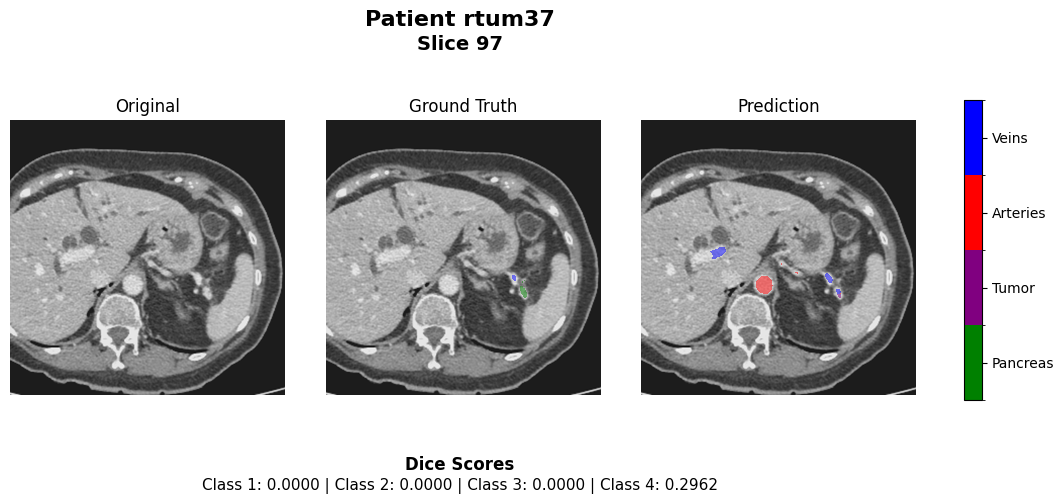

In [7]:
index = get_index(train_ds, 'rtum37', 97)
check_prediction(model, train_ds, index, device)

torch.Size([1, 5, 512, 512])
torch.Size([1, 512, 512])
tensor([0., 1.])
	pancreas pred: tensor([0., 1.]) | 85.0
	tumor pred: tensor([0.]) | 0.0
	pancreas mask: tensor([0., 1.])  | 49.0
	tumor mask: tensor([0.]) | 0.0
DICE SCORES: rtum44 - 89
Class            Function         Actual       Previous          MONAI        EQ func         EQ new
----------------------------------------------------------------------------------------------------
Pancreas         0.641791       0.641791       0.301188       0.641791              1              1
Tumor                 0.0            0.0            0.0            nan              0              0
Arteries         0.945995       0.945995       0.924895       0.945995              1              1
Veins            0.141538       0.141538       0.125224       0.141538              1              1


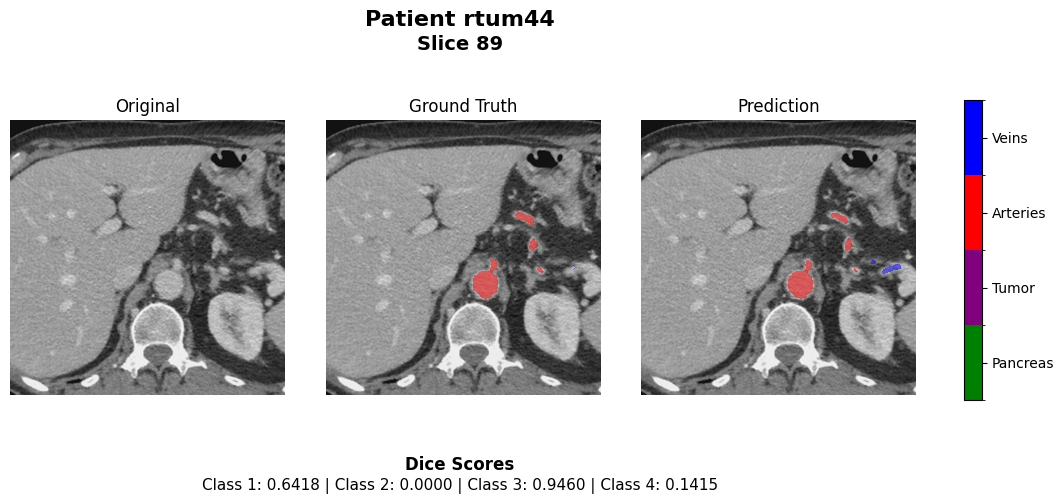

In [8]:
index = get_index(train_ds, 'rtum44', 89)
check_prediction(model, train_ds, index, device)

torch.Size([1, 5, 512, 512])
torch.Size([1, 512, 512])
tensor([0., 1.])
	pancreas pred: tensor([0., 1.]) | 310.0
	tumor pred: tensor([0., 1.]) | 365.0
	pancreas mask: tensor([0.])  | 0.0
	tumor mask: tensor([0., 1.]) | 320.0
DICE SCORES: rtum22 - 103
Class            Function         Actual       Previous          MONAI        EQ func         EQ new
----------------------------------------------------------------------------------------------------
Pancreas              0.0            0.0            0.0            nan              0              0
Tumor                 0.8            0.8         0.4627            0.8              1              1
Arteries         0.924468       0.924468       0.905999       0.924468              1              1
Veins            0.910663       0.910663       0.890842       0.910663              1              1


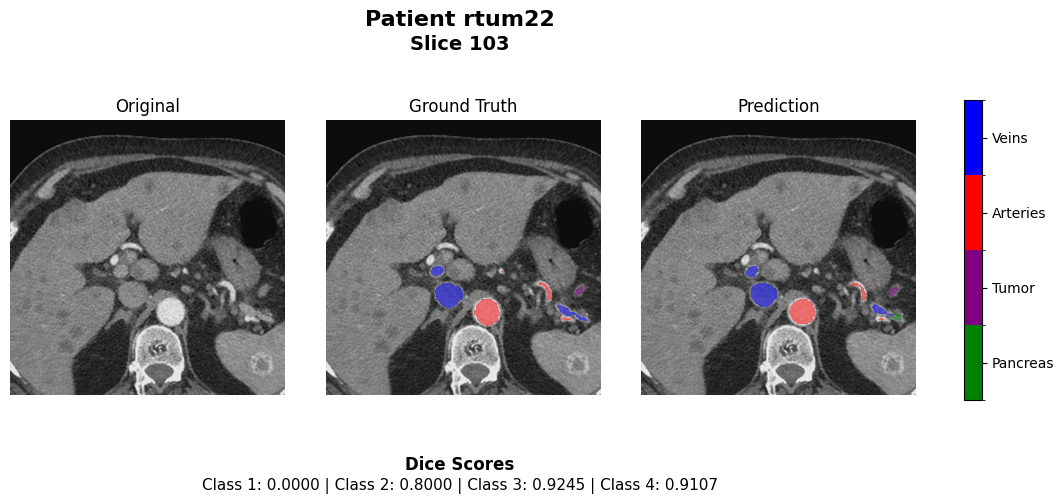

In [9]:
index = get_index(train_ds, 'rtum22', 103)
check_prediction(model, train_ds, index, device)

torch.Size([1, 5, 512, 512])
torch.Size([1, 512, 512])
tensor([0., 1.])
	pancreas pred: tensor([0., 1.]) | 2923.0
	tumor pred: tensor([0., 1.]) | 1.0
	pancreas mask: tensor([0., 1.])  | 3223.0
	tumor mask: tensor([0., 1.]) | 107.0
DICE SCORES: rtum78 - 35
Class            Function         Actual       Previous          MONAI        EQ func         EQ new
----------------------------------------------------------------------------------------------------
Pancreas         0.883176       0.883176       0.865908       0.883176              1              1
Tumor                 0.0            0.0       0.262801            0.0              1              1
Arteries         0.927306       0.927306       0.921771       0.927306              1              1
Veins            0.881575       0.881575       0.858805       0.881575              1              1


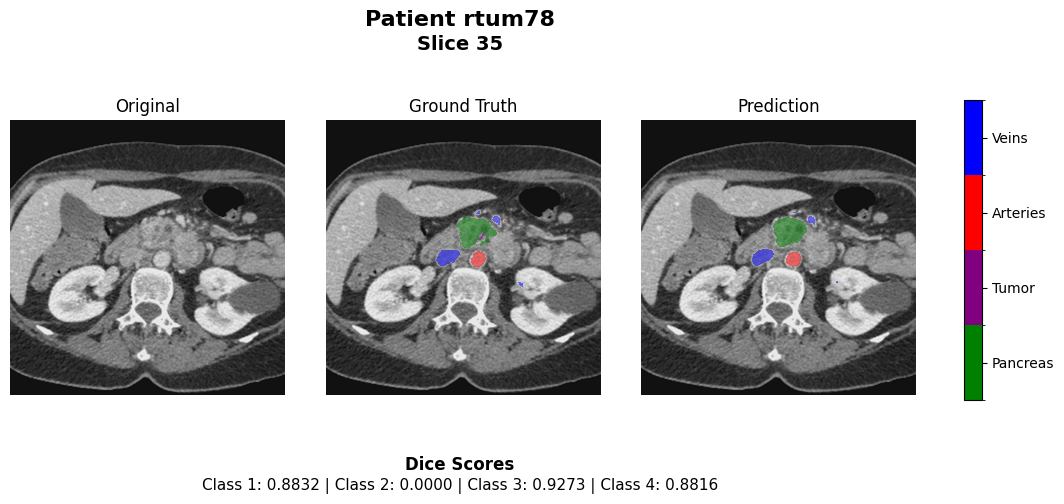

In [10]:
index = get_index(train_ds, 'rtum78', 35)
check_prediction(model, train_ds, index, device)